In [6]:
import numpy as np

Hiii 120


# Figure 2AC - Raw activity plots

In [2]:
import json

N_PFC_NEURONS = 500
N_MD_NEURONS = 2
TRIAL_TIME = 200

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial"
s_trial = 0
t_trial = 4800

# each neuron's activity is a row; column index is trial number
n_trials = t_trial - s_trial
rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
inMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
output_choice = np.zeros(n_trials)
task_input = np.zeros((2, n_trials))
q_values = np.zeros((2, n_trials))

for i in range(s_trial, t_trial):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        idx = i - s_trial
        
        # NOTE: We are only considering the cue period for analysis
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_trials[idx,:,:] = rPFC
        
        inMD = np.array(data["network_rates"]["MD_input"])
        inMD_trials[idx,:,:] = inMD

        rOutput = np.array(data["network_rates"]["r_output"])
        trial_output_choice = np.mean(rOutput, axis=0).argmax(0)
        output_choice[idx] = trial_output_choice
        
        trial_task_input = np.array(data["trial_data"]["input"])
        task_input[:,idx] = trial_task_input[:2]
        q_values[:,idx] = trial_task_input[2:]


In [51]:
def plot_stderr(ax, x, c, l):
    m = np.mean(x, 0)
    stderr = stats.sem(x, 0)
    ax.plot(m, c, label=l)
    ax.plot(m + stderr, 'grey')
    ax.plot(m - stderr, 'grey')
    
def plot_activity(fig, neuron_idx, rPFC_trials, cue, v1, v2, choice):
    # Plot over all trials
    ax1 = fig.add_subplot(3, 3, 1)
    neuron_activity = rPFC_trials[:,:]
    plot_stderr(ax1, neuron_activity, 'k', 'all trials')
    ax1.axvline(CUE_TIME, color='r', linestyle=':')
    ax1.set_title("Average trial activity")
    ax1.legend()

    # Plot cue UP trials vs cue DOWN trials
    ax2 = fig.add_subplot(3, 3, 2, sharey=ax1)
    cue_is_up = cue == 1
    cue_is_down = cue == -1
    cue_up_activity = rPFC_trials[cue_is_up,:]
    cue_down_activity = rPFC_trials[cue_is_down,:]
    plot_stderr(ax2, cue_up_activity, 'blue', 'Cue=UP')
    plot_stderr(ax2, cue_down_activity, 'orange', 'Cue=DOWN')
    ax2.axvline(CUE_TIME, color='r', linestyle=':')
    ax2.set_title("Cue (UP vs DOWN)")
    ax2.legend()

    # Plot choice UP trials vs choice DOWN trials
    ax3 = fig.add_subplot(3, 3, 3, sharey=ax1)
    choice_is_up = [c == 1 for c in choice]
    choice_is_down = [c == -1 for c in choice]
    choice_up_activity = rPFC_trials[choice_is_up,:]
    choice_down_activity = rPFC_trials[choice_is_down,:]
    plot_stderr(ax3, choice_up_activity, 'blue', "Choice=UP")
    plot_stderr(ax3, choice_down_activity, 'orange', "Choice=DOWN")
    ax3.axvline(CUE_TIME, color='r', linestyle=':')
    ax3.set_title("Behavioral Choice (UP vs DOWN)")
    ax3.legend()

def plot_correlations(fig, X, y_cue, y_out, m_rPFC_cue, m_rPFC_out, model_cue_fit, model_out_fit):
    # Plot CUE filtered trials as histogram of neuron activity during late cue period
    ax4 = fig.add_subplot(3, 3, 4)
    ax4.hist(y_cue[X[:,1] == 1], alpha=0.5, label='cue=up')
    ax4.hist(y_cue[X[:,1] == -1], alpha=0.5, label='cue=down')
    ax4.set_title("Cue (late) activity - filter=CUE")
    ax4.set_ylabel('Neuron activity per trial')
    ax4.legend()
    
    # Plot hist cue period filter=outcome
    ax5 = fig.add_subplot(3, 3, 5)    
    ax5.hist(y_cue[X[:,2] == 1], alpha=0.5, label='outcome=up')
    ax5.hist(y_cue[X[:,2] == -1], alpha=0.5, label='outcome=down')
    ax5.set_title("Cue (late) activity - filter=OUTCOME")
    ax5.set_ylabel('Neuron activity per trial')
    ax5.legend()
    
    # Plot regression bar plot
    pvalues_cue = model_cue_fit.pvalues
    ax6 = fig.add_subplot(3, 3, 6)
    ax6.bar(["b0", "cue", "choice"], model_cue_fit.params)
    ax6.set_ylabel("Beta")
    ax6.set_title(f"Cue (late) -- R^2={np.around(model_cue_fit.rsquared,3)}")
    ax6.text(-.3, 0.03, f"p={np.around(pvalues_cue[0],4)}", rotation=30.)
    ax6.text(0.7, 0.03, f"p={np.around(pvalues_cue[1],4)}", rotation=30.)
    ax6.text(1.7, 0.03, f"p={np.around(pvalues_cue[2],4)}", rotation=30.)
    ax6.set_ylim(-1,1)
    
    # Plot hist outcome period, filter=cue
    ax7 = fig.add_subplot(3, 3, 7)
    ax7.hist(y_out[X[:,1] == 1], alpha=0.5, label='cue=up')
    ax7.hist(y_out[X[:,1] == -1], alpha=0.5, label='cue=down')
    ax7.set_title("Outcome (late) activity - filter=CUE")
    ax7.set_ylabel('Neuron activity per trial')
    ax7.legend()
                   
    # Plot hist outcome period, filter=outcome
    ax8 = fig.add_subplot(3, 3, 8)    
    ax8.hist(y_out[X[:,2] == 1], alpha=0.5, label='outcome=up')
    ax8.hist(y_out[X[:,2] == -1], alpha=0.5, label='outcome=down')
    ax8.set_title("Outcome (late) activity - filter=OUTCOME")
    ax8.set_ylabel('Neuron activity per trial')
    ax8.legend()
    
    # Plot regression bar plot
    pvalues_out = model_out_fit.pvalues
    ax9 = fig.add_subplot(3, 3, 9)
    ax9.bar(["b0", "cue", "choice"], model_out_fit.params)
    ax9.set_ylabel("Beta")
    ax9.set_title(f"Outcome (late) -- R^2={np.around(model_out_fit.rsquared,3)}")
    ax9.text(-.3, 0.03, f"p={np.around(pvalues_out[0],4)}", rotation=30.)
    ax9.text(0.7, 0.03, f"p={np.around(pvalues_out[1],4)}", rotation=30.)
    ax9.text(1.7, 0.03, f"p={np.around(pvalues_out[2],4)}", rotation=30.)
    ax9.set_ylim(-1,1)
    

In [53]:
import statsmodels.api as sm
import math
from scipy import stats
import matplotlib.pyplot as plt
import random

CUE_TIME = 100
TRIAL_TIME = 200
ASSC_LEVELS = ['90', '10', '90', '70', '90', '10', '70', '30', '90', '50', '90', '10']
SAVE_DIR = "/om2/group/halassa/PFCMD-ali-sabrina/030121_histograms_regression/neuron_figs"

for neuron_idx in range(0, 500, 5):
    print("Running neuron: " + str(neuron_idx))

    # Randomly sample trials in the 2nd half of association levels
    trials = []
    for n_bin in range(len(ASSC_LEVELS)):
        trial_s = n_bin * 400 + 150
        trial_t = (n_bin + 1) * 400
        trials.extend(random.sample(range(trial_s,trial_t), 20))

    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 4))
    cuetime_t = CUE_TIME

    outcome_s = math.floor(TRIAL_TIME - (CUE_TIME / 4))
    outcome_t = TRIAL_TIME

    cue = task_input[0,trials]
    choice = output_choice[trials]
    strategy = task_input[0,trials] == choice
    v1 = q_values[0,trials]
    v2 = q_values[1,trials]
    rPFC_neuron = rPFC_trials[trials,:,neuron_idx]

    cue[cue == 0] = -1
    choice[choice == 0] = -1
    strategy = [1 if is_match else -1 for is_match in strategy]

    ## -- FIGURE PLOTTING -- 
    fig = plt.figure(figsize=(22,16))

    # Activity
    plot_activity(fig, neuron_idx, rPFC_neuron, cue, v1, v2, choice)

    # V1/V2
    X = np.transpose([np.ones(len(cue)), cue, choice])

    y_cue = np.mean(rPFC_neuron[:,cuetime_s:cuetime_t],1)
    model_cue = sm.OLS(y_cue,X)
    model_cue_fit = model_cue.fit()
    m_rPFC_cue = np.mean(rPFC_neuron[:,cuetime_s:cuetime_t],1)

    y_out = np.mean(rPFC_neuron[:,outcome_s:outcome_t],1)
    model_out = sm.OLS(y_out,X)
    model_out_fit = model_out.fit()
    m_rPFC_out = np.mean(rPFC_neuron[:,outcome_s:outcome_t],1)

    plot_correlations(fig, X, y_cue, y_out, m_rPFC_cue, m_rPFC_out, model_cue_fit, model_out_fit)
    fig.suptitle(f"Neuron idx = {neuron_idx} \n Association Levels={ASSC_LEVELS}", fontsize=16)
    
    plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
    plt.close()

Running neuron: 0
Running neuron: 5
Running neuron: 10
Running neuron: 15
Running neuron: 20
Running neuron: 25
Running neuron: 30
Running neuron: 35
Running neuron: 40
Running neuron: 45
Running neuron: 50
Running neuron: 55
Running neuron: 60
Running neuron: 65
Running neuron: 70
Running neuron: 75
Running neuron: 80
Running neuron: 85
Running neuron: 90
Running neuron: 95
Running neuron: 100
Running neuron: 105
Running neuron: 110
Running neuron: 115
Running neuron: 120
Running neuron: 125
Running neuron: 130
Running neuron: 135
Running neuron: 140
Running neuron: 145
Running neuron: 150
Running neuron: 155
Running neuron: 160
Running neuron: 165
Running neuron: 170
Running neuron: 175
Running neuron: 180
Running neuron: 185
Running neuron: 190
Running neuron: 195
Running neuron: 200
Running neuron: 205
Running neuron: 210
Running neuron: 215
Running neuron: 220
Running neuron: 225
Running neuron: 230
Running neuron: 235
Running neuron: 240
Running neuron: 245
Running neuron: 250
Ru

# Beta Distributions

In [ ]:
betas_cue = np.zeros((50, 8))
pvals_cue = np.zeros((50, 8))

betas_out = np.zeros((50, 8))
pvals_out = np.zeros((50, 8))

for i, neuron_idx in enumerate(range(0, 500, 10)):
    # Randomly sample trials in the 2nd half of association levels
    trials = []
    for n_bin in range(12):
        trial_s = n_bin * 400 + 150
        trial_t = (n_bin + 1) * 400
        trials.extend(random.sample(range(trial_s,trial_t), 20))

    cuetime_s = math.floor(CUE_TIME/2)
    cuetime_t = CUE_TIME

    outcome_s = math.floor(CUE_TIME + (TRIAL_TIME - CUE_TIME) / 2)
    outcome_t = TRIAL_TIME

    cue = task_input[0,trials]
    choice = output_choice[trials]
    strategy = task_input[0,trials] == choice
    v1 = q_values[0,trials]
    v2 = q_values[1,trials]
    rPFC_neuron = rPFC_trials[trials,:,neuron_idx]

    cue[cue == 0] = -1
    choice[choice == 0] = -1
    strategy = [1 if is_match else -1 for is_match in strategy]

    m_inMD1_cue = np.mean(inMD_trials[trials,cuetime_s:cuetime_t,0],1)
    m_inMD2_cue = np.mean(inMD_trials[trials,cuetime_s:cuetime_t,1],1)
    X_MD_cue = np.transpose([np.ones(len(v1)), v1, v2, cue, choice, strategy, m_inMD1_cue, m_inMD2_cue])
    y_MD_cue = np.mean(rPFC_neuron[:,cuetime_s:cuetime_t],1)
    model_MD_cue = sm.OLS(y_MD_cue, X_MD_cue)
    model_MD_cue_fit = model_MD_cue.fit()
    
    betas_cue[i,:] = model_MD_cue_fit.params
    pvals_cue[i,:] = model_MD_cue_fit.pvalues

    m_inMD1_out = np.mean(inMD_trials[trials,outcome_s:outcome_t,0],1)
    m_inMD2_out = np.mean(inMD_trials[trials,outcome_s:outcome_t,1],1)
    X_MD_out = np.transpose([np.ones(len(v1)), v1, v2, cue, choice, strategy, m_inMD1_out, m_inMD2_out])
    y_MD_out = np.mean(rPFC_neuron[:,outcome_s:outcome_t],1)
    model_MD_out = sm.OLS(y_MD_out, X_MD_out)
    model_MD_out_fit = model_MD_out.fit()
    
    betas_out[i,:] = model_MD_out_fit.params
    pvals_out[i,:] = model_MD_out_fit.pvalues

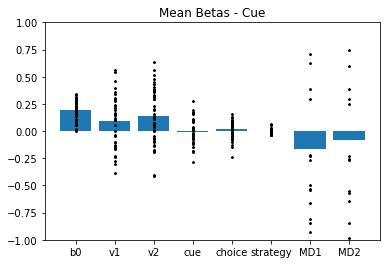

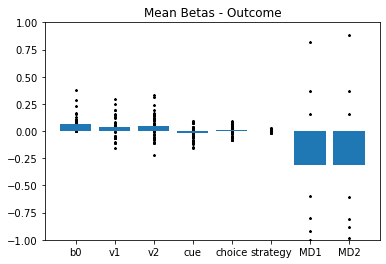

In [138]:
plt.figure()
m_cue = []
for i in range(8):
    betas = betas_cue[pvals_cue[:,i] < 0.05,i]
    m_cue.append(np.mean(betas))
    plt.scatter(np.ones(len(betas)) * i, betas, s=5, c='k', marker='*', zorder=10)
plt.bar(["b0", "v1", "v2", "cue", "choice", "strategy", "MD1", "MD2"], m_cue)
plt.title("Mean Betas - Cue")
plt.ylim(-1,1)
plt.show()

plt.figure()
m_out = []
for i in range(8):
    betas = betas_out[pvals_out[:,i] < 0.05,i]
    m_out.append(np.mean(betas))
    plt.scatter(np.ones(len(betas)) * i, betas, s=5, c='k', marker='*')
plt.bar(["b0", "v1", "v2", "cue", "choice", "strategy", "MD1", "MD2"], m_out)
plt.title("Mean Betas - Outcome")
plt.ylim(-1,1)
plt.show()